# Reliability anaysis


## Packages and Helpers

In [28]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns

## Read Processed Data

In [29]:
# load overall df
all_data = pd.read_csv("human_data/items_per_person.csv")

/var/folders/g6/6tx7kz_51_92m63qx0q2c2lw0000gn/T/ipykernel_21620/2819857533.py:2: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv("human_data/items_per_person.csv")


In [30]:
all_data[all_data["experiment"] == "DM scale"]

,experiment,partid,item,score,category
126588,DM scale,64000401,1.0,3.0,NaN
126589,DM scale,64004701,1.0,1.0,NaN
126590,DM scale,64006401,1.0,3.0,NaN
126591,DM scale,64006901,1.0,3.0,NaN
126592,DM scale,64007901,1.0,2.0,NaN
...,...,...,...,...,...
153709,DM scale,68050801,18.0,3.0,NaN
153710,DM scale,68050901,18.0,1.0,NaN
153711,DM scale,68051101,18.0,3.0,NaN
153712,DM scale,68051301,18.0,3.0,NaN


## Normalize item scores where tasks have different scales on different items
- AUDIT, FTND, GABS, PG

In [31]:
def normalize_per_scale(data):
    scales_to_normalize = ["AUDIT scale", "FTND scale", "GABS scale", "PG scale"]

    data = data.copy()

    # Loop over each experiment you want to normalize
    for scale in scales_to_normalize:
        mask = data["experiment"] == scale

        if mask.sum() == 0:
            continue  # skip if scale not present

        # Normalize score
        data.loc[mask, "score"] = (
            data.loc[mask, "score"] - data.loc[mask, "score"].min()
        ) / (data.loc[mask, "score"].max() - data.loc[mask, "score"].min())

        # # Normalize score_top_n
        # data.loc[mask, "score_top_n"] = (
        #     data.loc[mask, "score_top_n"] - data.loc[mask, "score_top_n"].min()
        # ) / (data.loc[mask, "score_top_n"].max() - data.loc[mask, "score_top_n"].min())

    return data

all_data = normalize_per_scale(all_data)


## Chronbach's Alpha

In [32]:
# function:
def compute_cronbach_alpha(score = "score"):
    results = []

    # loop through experiments
    for exp, exp_data in all_data.groupby("experiment"):
        
        # check whether this experiment has subcategories
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            # compute alpha per category (domain)
            for domain, domain_data in exp_data.groupby("category"):
                df_wide = domain_data.pivot_table(
                    index="partid", columns="item", values=score
                )
                #print(df_wide)
                if df_wide.shape[1] > 1:
                    alpha, ci = pg.cronbach_alpha(df_wide)
                else:
                    alpha, ci = None, (None, None)
                
                results.append({
                    "experiment": exp,
                    "domain": domain,
                    "alpha": alpha,
                    "alpha_CI": ci
                })
        else:
            # compute alpha for the whole experiment
            df_wide = exp_data.pivot_table(
                index="partid", columns="item", values=score
            )
            #print(exp, df_wide.std().describe())
            if df_wide.shape[1] > 1:
                alpha, ci = pg.cronbach_alpha(df_wide)
            else:
                alpha, ci = None, (None, None)
            
            results.append({
                "experiment": exp,
                "domain": "total",  # no subdomain
                "alpha": alpha,
                "alpha_CI": ci
            })

    # convert to DataFrame
    return(pd.DataFrame(results))



In [33]:
# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
alpha_df = compute_cronbach_alpha()

display(alpha_df)

,experiment,domain,alpha,alpha_CI
0,AUDIT scale,total,0.769181,"[0.752, 0.786]"
1,BARRAT scale,BISa,0.563278,"[0.529, 0.596]"
2,BARRAT scale,BISm,0.730814,"[0.71, 0.751]"
3,BARRAT scale,BISn,0.670551,"[0.645, 0.695]"
4,BART task,total,0.901934,"[0.895, 0.909]"
5,CARE scale,CAREa,0.576473,"[0.544, 0.608]"
6,CARE scale,CAREs,0.290463,"[0.233, 0.345]"
7,CARE scale,CAREw,0.487103,"[0.443, 0.528]"
8,CCT task,total,0.897720,"[0.89, 0.905]"
9,DAST scale,total,0.803377,"[0.789, 0.817]"


## Split-half Reliability

In [34]:
def split_half_reliability(df_items, n_splits=100):
    """Compute average split-half reliability (Spearman-Brown corrected)."""

    k = df_items.shape[1]
    
    if k < 2:
        return None, None

    cols = df_items.columns
    results = []

    for _ in range(n_splits):
        shuffled = np.random.permutation(cols)
        half1 = shuffled[:k//2]
        half2 = shuffled[k//2:]

        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)

        r, _ = pearsonr(s1, s2)

        if np.isfinite(r):
            r_sb = (2 * r) / (1 + r)  # Spearman-Brown correction
            results.append(r_sb)

    if len(results) == 0:
        return None, None
    
    return np.mean(results), np.std(results)


In [35]:
def compute_split_half_reliability(score="score"):
    rows = []  # final list of results

    for exp, exp_data in all_data.groupby("experiment"):

        # case 1: experiments with domains
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            for domain, domain_data in exp_data.groupby("category"):

                df_wide = domain_data.pivot_table(
                    index="partid", columns="item", values=score
                )

                mean_rsb, sd_rsb = split_half_reliability(df_wide)

                rows.append({
                    "experiment": exp,
                    "domain": domain,
                    "split_half_mean": mean_rsb,
                    "split_half_sd": sd_rsb
                })

        # case 2: experiments without domains
        else:
            df_wide = exp_data.pivot_table(
                index="partid", columns="item", values=score
            )

            mean_rsb, sd_rsb = split_half_reliability(df_wide)

            rows.append({
                "experiment": exp,
                "domain": "total",
                "split_half_mean": mean_rsb,
                "split_half_sd": sd_rsb
            })

    return pd.DataFrame(rows)


In [36]:
split_half_reliability = compute_split_half_reliability()
split_half_reliability

,experiment,domain,split_half_mean,split_half_sd
0,AUDIT scale,total,0.791003,0.045717
1,BARRAT scale,BISa,0.571750,0.044242
2,BARRAT scale,BISm,0.730097,0.045820
3,BARRAT scale,BISn,0.673291,0.064948
4,BART task,total,0.900256,0.014760
5,CARE scale,CAREa,0.630846,0.116605
6,CARE scale,CAREs,0.329146,0.305880
7,CARE scale,CAREw,0.512329,0.179631
8,CCT task,total,0.828701,0.095171
9,DAST scale,total,0.814059,0.035835


## Visualize Distributions per model

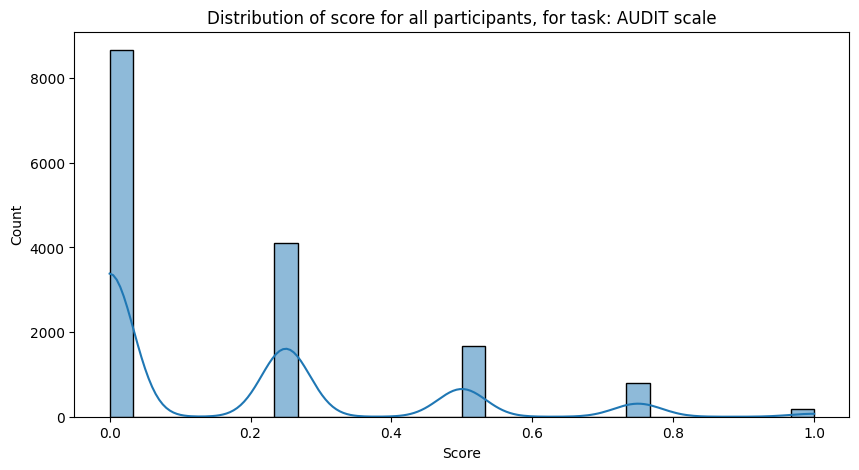

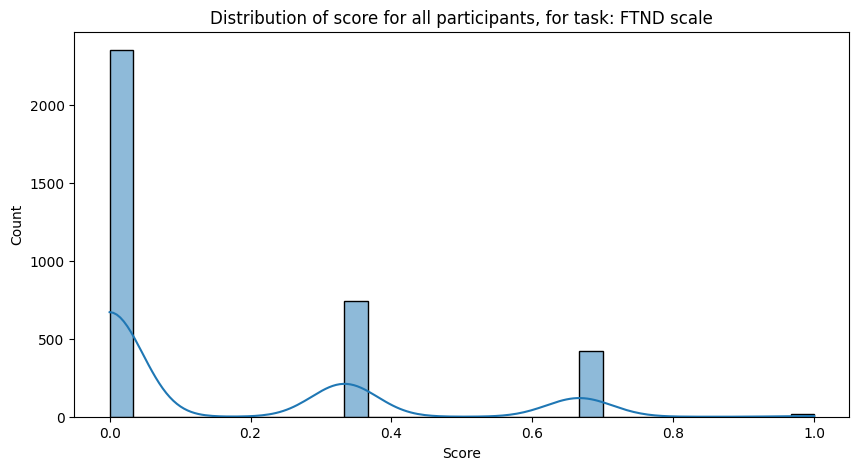

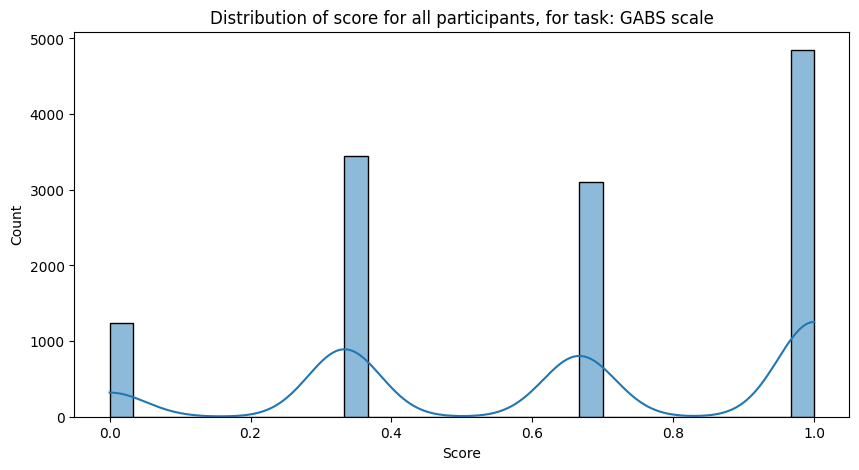

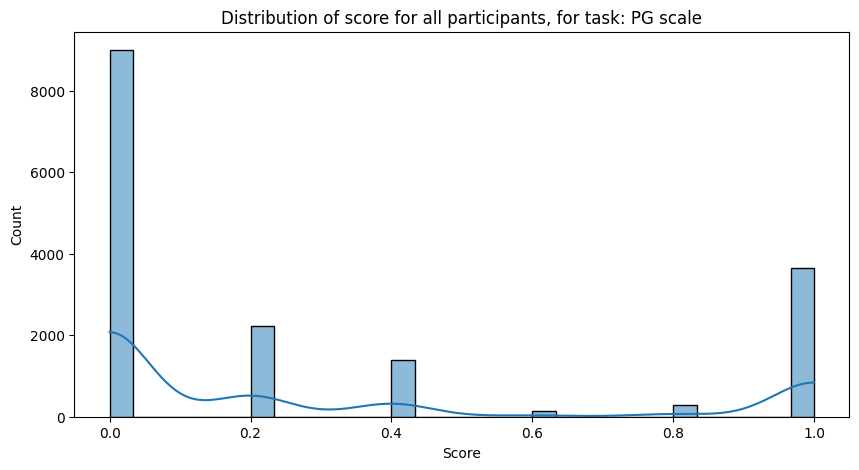

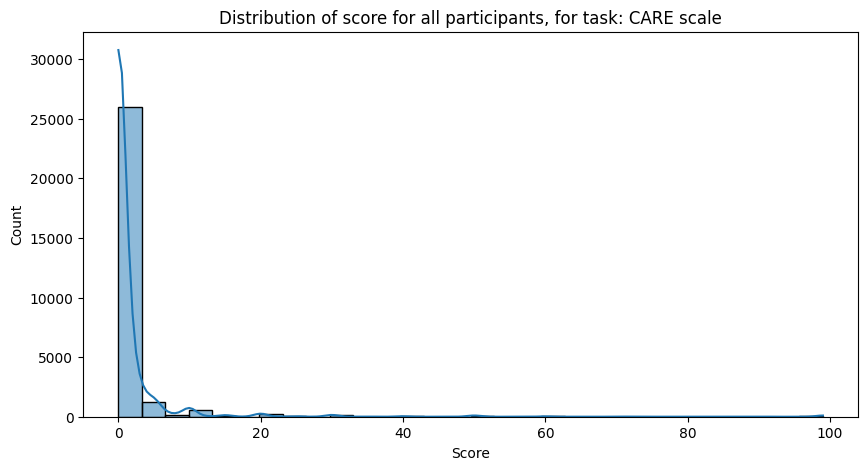

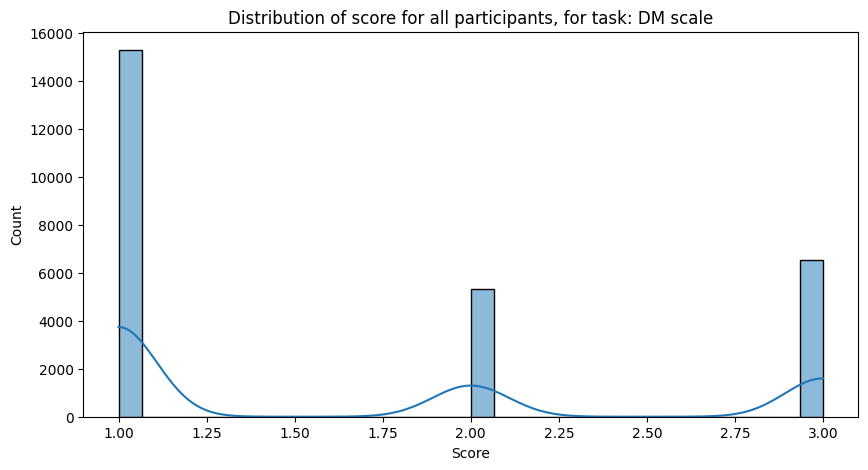

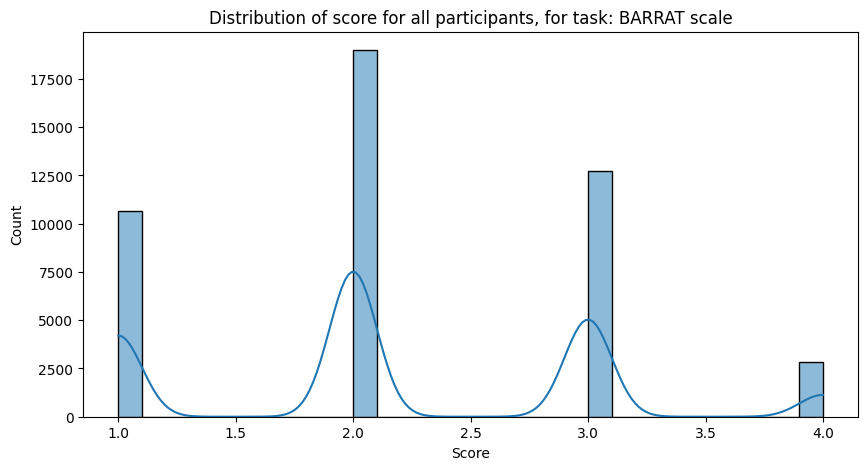

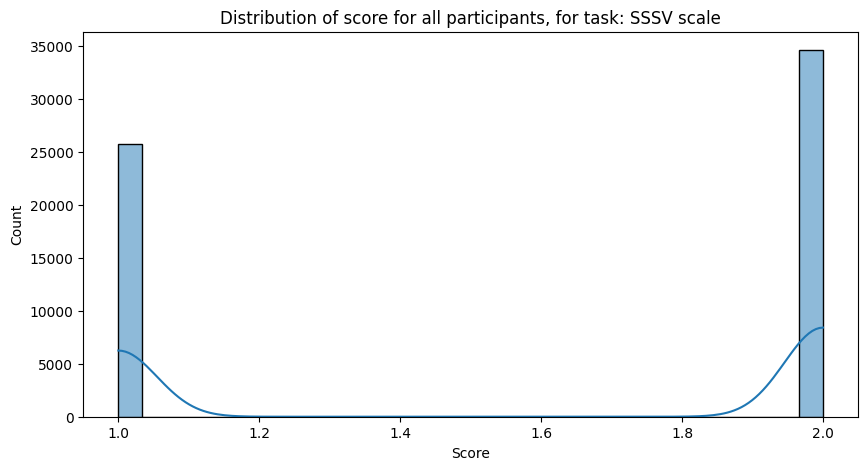

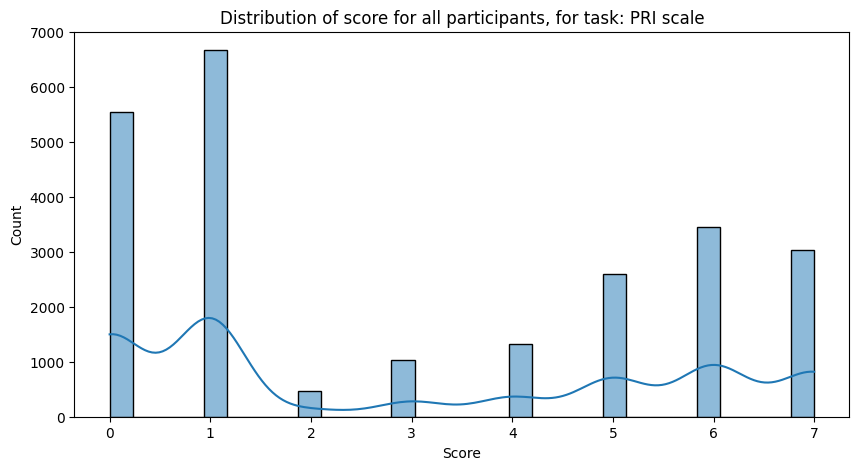

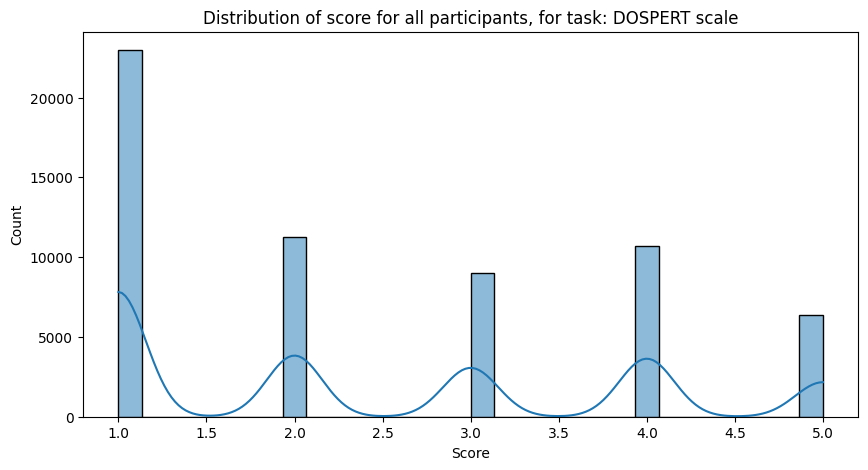

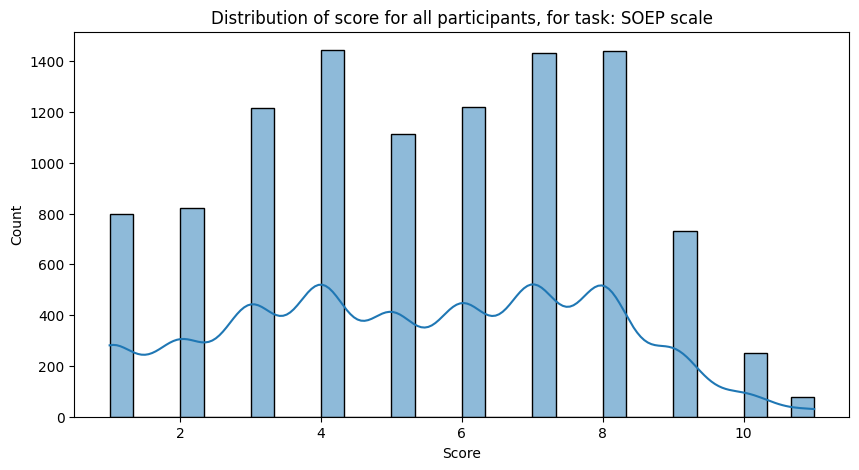

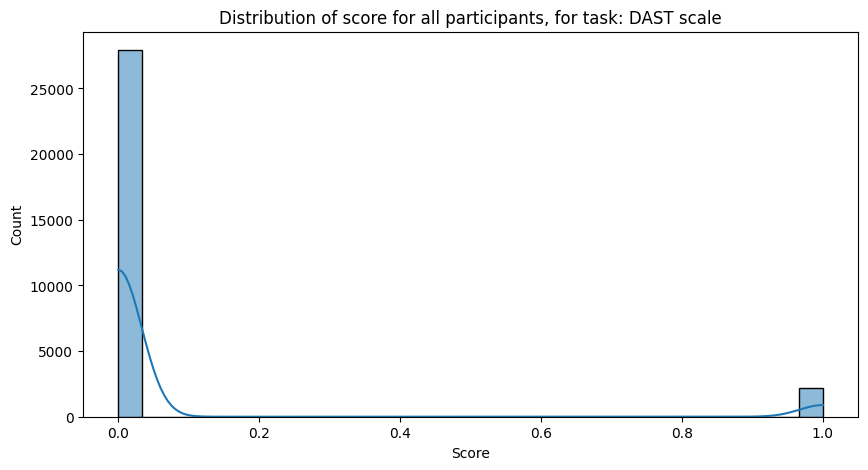

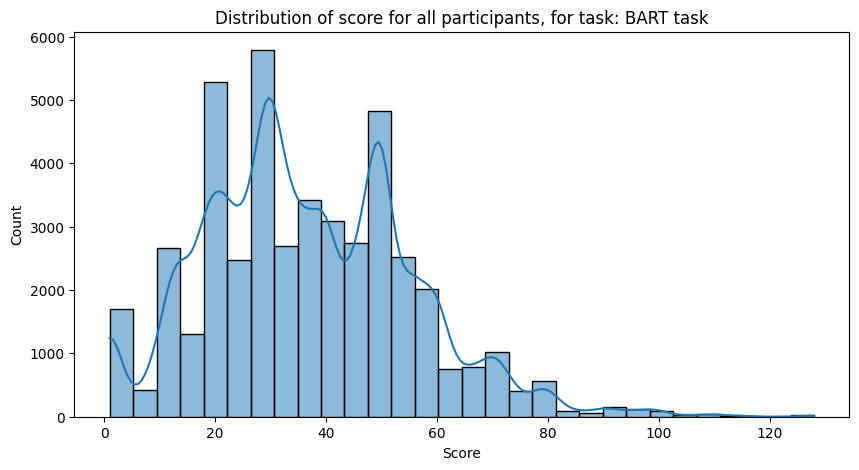

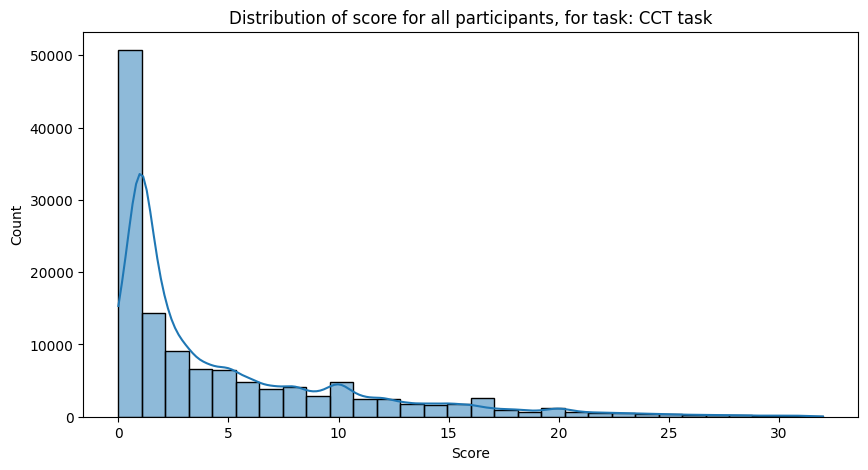

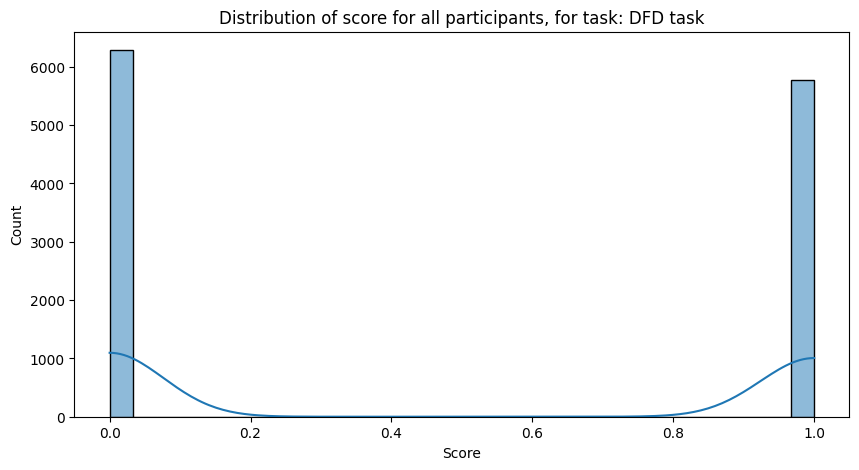

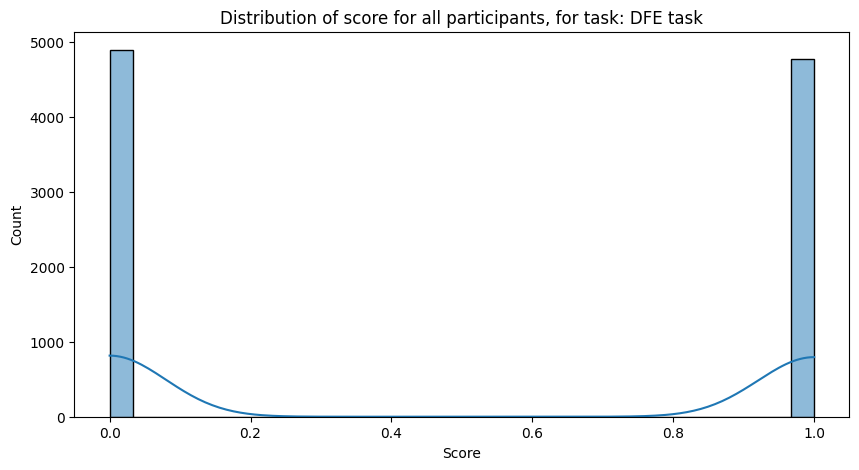

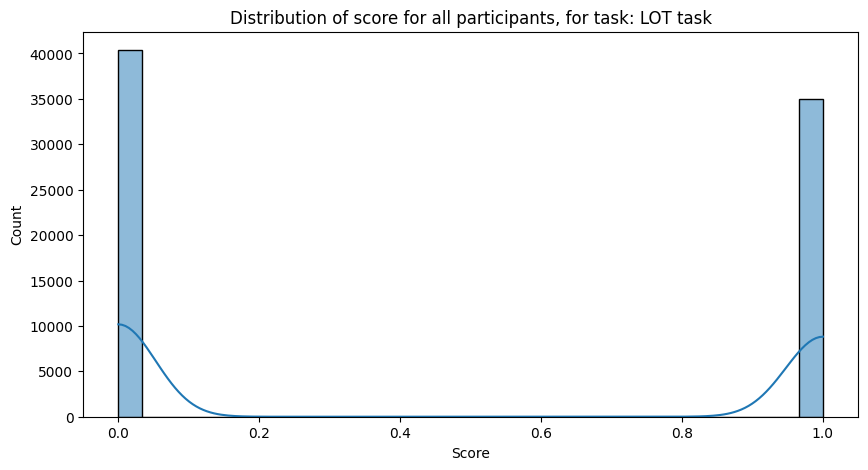

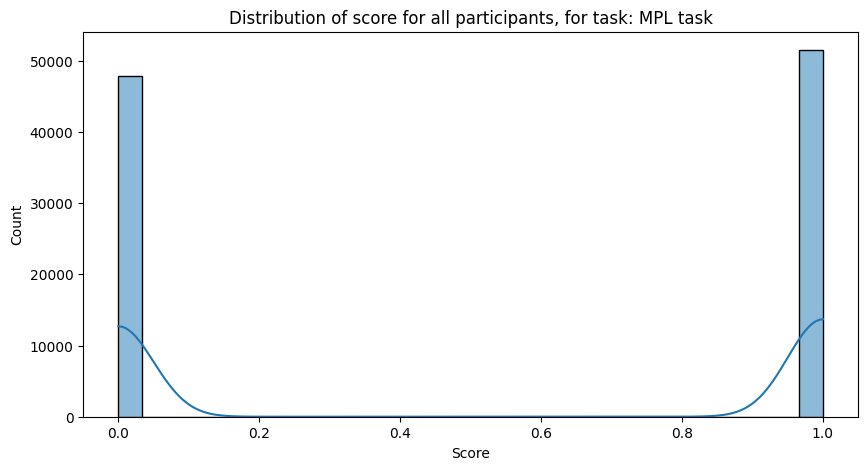

In [37]:
# Visualise distribution (focus on variance) of logprobs

task_names = all_data['experiment'].unique()

#for model_name in model_names:
for task_name in task_names:
    df_plot = all_data[
        #(all_data['model'] == model_name) &
        (all_data['experiment'] == task_name)
    ]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_plot, x="score", kde=True, bins=30)  
    plt.title(f'Distribution of score for all participants, for task: {task_name}')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.show()